In [32]:
#importing nesessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import date
import seaborn as sns
from scipy.stats import pearsonr

In [12]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [13]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [26]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y,1)

    return bs_slope_reps, bs_intercept_reps


In [3]:
#reading input dataset from csv to dataframe
df = pd.read_csv('..\Step 1. Data Wrangling\monthly-production.csv')
df[['RPT_DATE','Dt_Treat']] = df[['RPT_DATE','Dt_Treat']].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291495 entries, 0 to 291494
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   API            291495 non-null  int64         
 1   Pool_Nm        291495 non-null  object        
 2   RPT_DATE       291495 non-null  datetime64[ns]
 3   DAYS_PROD      291495 non-null  int64         
 4   BBLS_OIL_COND  291495 non-null  int64         
 5   OIL_RUNS       291495 non-null  int64         
 6   BBLS_WTR       291495 non-null  int64         
 7   MCF_GAS        291495 non-null  int64         
 8   MCF_SOLD       291495 non-null  int64         
 9   FLARED         291495 non-null  int64         
 10  VENTED         291495 non-null  int64         
 11  Dt_Treat       291495 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(9), object(1)
memory usage: 26.7+ MB


In [4]:
df

,API,Pool_Nm,RPT_DATE,DAYS_PROD,BBLS_OIL_COND,OIL_RUNS,BBLS_WTR,MCF_GAS,MCF_SOLD,FLARED,VENTED,Dt_Treat
0,33007001030000,MADISON,2009-01-01,31,705,704,5206,51,24,0,0,2010-12-16
1,33007001030000,MADISON,2009-02-01,28,597,597,4603,46,25,0,0,2010-12-16
2,33007001030000,MADISON,2009-03-01,31,701,704,5014,61,33,0,0,2010-12-16
3,33007001030000,MADISON,2009-04-01,30,690,687,4853,65,37,0,0,2010-12-16
4,33007001030000,MADISON,2009-05-01,31,734,736,5116,58,32,0,0,2010-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...
291490,33105036600000,BAKKEN,2015-02-01,28,10270,10197,9011,11216,0,11216,0,2014-11-19
291491,33105036750000,BAKKEN,2014-11-01,0,0,0,0,0,0,0,0,2014-11-11
291492,33105036750000,BAKKEN,2014-12-01,23,5690,5231,26625,8492,0,8492,0,2014-11-11
291493,33105036750000,BAKKEN,2015-01-01,27,9275,9602,14695,11213,0,11213,0,2014-11-11


In [5]:
#Loading cleaned dataset with features and production metric
df_ml = pd.read_csv('..\Step 1. Data Wrangling\DataWrangling_clean_dataset.csv')
df_ml

,Unnamed: 0,api,bottom,fluid_bbl,fluid_bbl_per_ft,fluid_gal,fluid_gal_per_ft,ft_per_stage,lateral_length,max_treat_press,...,Footages,Field_Name,Produced_Pools,Wellbore,Latitude,Longitude,Well_Type,Well_Status,CTB,Well_Status_Date
0,0,33007015830000,9441,47,1,1998,46,43,43,0,...,906 FSL 1197 FEL,BIG STICK,MADISON,DIRECTIONAL,47.112737,-103.418030,OG,A,406270.0,2010-05-26
1,1,33007016320000,20810,57661,6,2421762,252,319,9586,8461,...,2400 FSL 300 FEL,ST. DEMETRIUS,BAKKEN,HORIZONTAL,47.088015,-103.244706,OG,A,117768.0,2012-07-25
2,2,33007016390000,7942,23,5,1000,250,4,4,0,...,2100 FSL 1980 FEL,WILDCAT,TYLER,VERTICAL,46.736696,-103.553665,OG,A,118216.0,2011-10-23
3,3,33007016410000,20457,48944,5,2055648,214,9572,9572,8968,...,505 FSL 541 FEL,BIG STICK,BAKKEN,HORIZONTAL,47.111642,-103.415385,OG,A,118502.0,2010-11-11
4,4,33007016440000,9338,59,0,2500,39,64,64,0,...,990 FSL 640 FEL,BIG STICK,MADISON,VERTICAL,47.069474,-103.415609,OG,A,406270.0,2010-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841,5841,33105022070000,19357,66738,12,2802996,510,312,11497,9486,...,1100 FNL 300 FWL,TRUAX,BAKKEN,HORIZONTAL,48.108048,-103.343890,OG,A,120857.0,2012-01-28
5842,5842,33105022840000,21123,73233,17,3075786,753,279,10083,9341,...,350 FNL 1715 FEL,WILLISTON,BAKKEN,HORIZONTAL,48.196664,-103.567636,OG,A,121146.0,2011-12-02
5843,5843,33105024670000,19260,52566,5,2207772,251,313,18297,8000,...,331 FNL 2030 FWL,STRANDAHL,BAKKEN,HORIZONTAL,48.459011,-103.876229,OG,A,122001.0,2012-06-21
5844,5844,33105024800000,20761,89045,21,3739890,911,286,8700,9906,...,2050 FNL 270 FWL,TRUAX,BAKKEN,HORIZONTAL,48.090853,-103.279816,OG,A,122074.0,2013-06-06


In [6]:
df_ml.keys()

Index(['Unnamed: 0', 'api', 'bottom', 'fluid_bbl', 'fluid_bbl_per_ft',
       'fluid_gal', 'fluid_gal_per_ft', 'ft_per_stage', 'lateral_length',
       'max_treat_press', 'max_treat_rate', 'propp_lbs', 'propp_lbs_per_ft',
       'stages', 'top', 'treatment_date', 'number_treatments', 'interval',
       'cum_oil_365', 'file_no', 'Current_Operator', 'Current_Well_Name',
       'Lease_Name', 'Lease_Number', 'Original_Operator', 'Original_Well_Name',
       'Spud_Date', 'TD', 'County_Name', 'Township', 'Range', 'Section', 'QQ',
       'Footages', 'Field_Name', 'Produced_Pools', 'Wellbore', 'Latitude',
       'Longitude', 'Well_Type', 'Well_Status', 'CTB', 'Well_Status_Date'],
      dtype='object')

In [7]:
#Dataframe with days before treatment and production metric
df_min = df[['API','RPT_DATE','Dt_Treat']]
df_min = df_min.groupby('API').agg('min')
df_min['TreatDays']=df_min['Dt_Treat']-df_min['RPT_DATE']
df_min.reset_index()
#df_min[df_min.index==33007016320000]
df_min=df_min.merge(df_ml, left_on='API', right_on='api')[['api','TreatDays','cum_oil_365']]
df_min['TreatDays']=[i.days for i in df_min['TreatDays']]
df_min

,api,TreatDays,cum_oil_365
0,33007015830000,11,28758.0
1,33007016320000,18,19649.0
2,33007016380000,-3,39719.0
3,33007016390000,-175,10203.0
4,33007016410000,0,33166.0
...,...,...,...
5841,33105031490000,0,49423.0
5842,33105031600000,19,95125.0
5843,33105031610000,-1,53310.0
5844,33105031620000,-25,89055.0


(-200, 200)

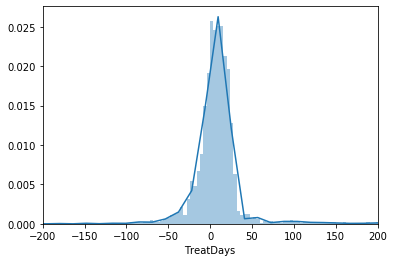

In [8]:
sns.distplot(df_min['TreatDays'],bins=500)
#ax.set_yscale('log')
plt.xlim((-200,200))

C:\Users\olyab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


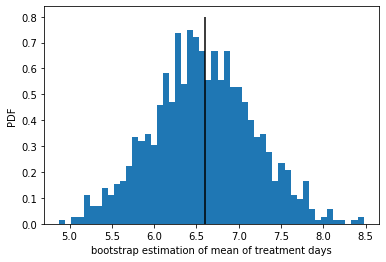

In [22]:
mean_treat_days_bs = draw_bs_reps(df_min['TreatDays'], np.mean, size=1000)
# Make a histogram of the results
_ = plt.hist(mean_treat_days_bs, bins=50,normed=True)
_ = plt.xlabel('bootstrap estimation of mean of treatment days')
_ = plt.vlines(np.mean(df_min['TreatDays']),0,0.8)
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

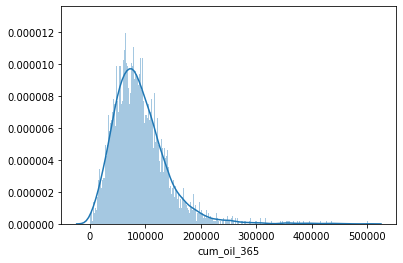

In [9]:
sns.distplot(df_min['cum_oil_365'],bins=500)
#ax.set_yscale('log')
#plt.xlim((-200,200))

C:\Users\olyab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


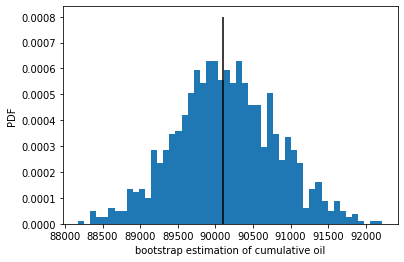

In [25]:
mean_cum_oil_365_bs = draw_bs_reps(df_min['cum_oil_365'], np.mean, size=1000)
# Make a histogram of the results
_ = plt.hist(mean_cum_oil_365_bs, bins=50,normed=True)
_ = plt.xlabel('bootstrap estimation of cumulative oil')
_ = plt.vlines(np.mean(df_min['cum_oil_365']),0,0.0008)
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [10]:
a, b = np.polyfit(df_min['TreatDays'],df_min['cum_oil_365'],1)
# Make theoretical line to plot
x = np.array([-200,200])
y = a * x + b

(-250, 250)

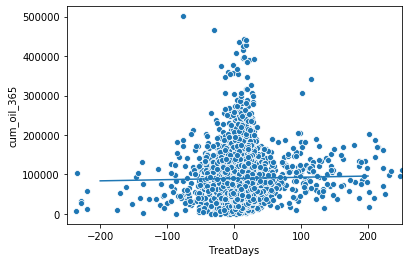

In [11]:
sns.scatterplot(data=df_min,x='TreatDays',y='cum_oil_365')
plt.plot(x, y)
plt.xlim(-250,250)

[ 3.84742396 67.76751437]


C:\Users\olyab\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


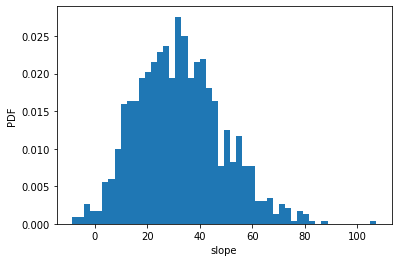

In [27]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(df_min['TreatDays'],df_min['cum_oil_365'],1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps,[2.5, 97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, normed=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

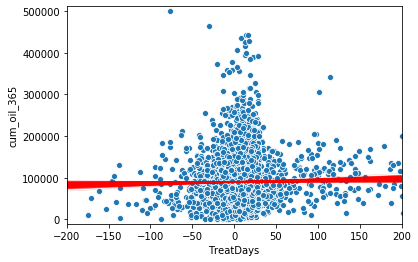

In [29]:
# Generate array of x-values for bootstrap lines: x
x = np.array([-200,200])

# Plot the bootstrap lines
for i in range(1000):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
sns.scatterplot(data=df_min,x='TreatDays',y='cum_oil_365')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('TreatDays')
_ = plt.ylabel('cum_oil_365')
plt.xlim((-200,200))
plt.margins(0.02)
plt.show()

In [33]:
r_obs = pearsonr(df_min['TreatDays'],df_min['cum_oil_365'])
r_obs

(0.028858143871844592, 0.0273520522889145)

In [41]:
# Initialize permutation replicates: perm_replicates
perm_replicates = []

# Draw replicates
for i in range(1000):
    # Permute illiteracy measurments: illiteracy_permuted
    cum_oil_permuted = np.random.permutation(df_min['cum_oil_365'])

    # Compute Pearson correlation
    perm_replicates.append(pearsonr(df_min['TreatDays'],cum_oil_permuted)[0])

In [51]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(perm_replicates,[2.5,97.5])
conf_int

array([-0.02552324,  0.02479974])

C:\Users\olyab\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


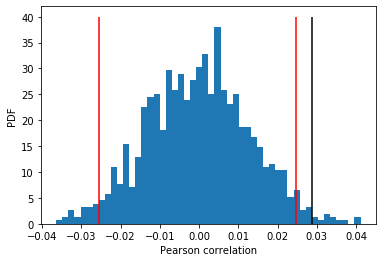

In [58]:
# Plot the histogram
_ = plt.hist(perm_replicates, bins=50, normed=True)
_ = plt.xlabel('Pearson correlation')
_ = plt.vlines(r_obs[0],0,40)
_ = plt.vlines(conf_int[0],0,40,'r')
_ = plt.vlines(conf_int[1],0,40,'r')
_ = plt.ylabel('PDF')
plt.show()

In [47]:
# Compute p-value: p
p = np.sum(perm_replicates>=r_obs[0])/len(perm_replicates)
print('p-val =', p)

p-val = 0.012


In [ ]:
Our hypothesis 